In [1]:
import torch
import matplotlib.pyplot as plt
import tqdm as tqdm

Reconstructed outputs saved in ../data/reconstructed_outputs


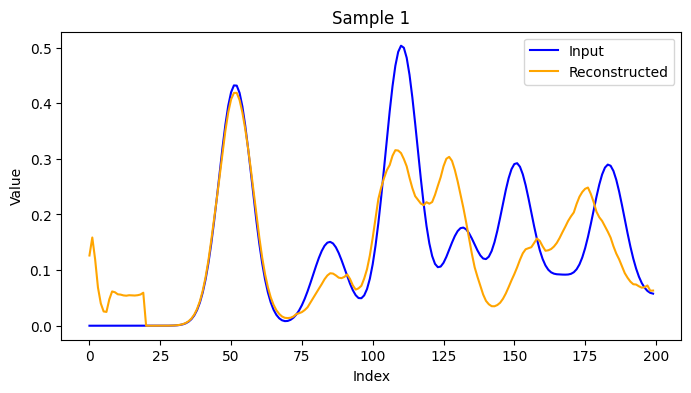

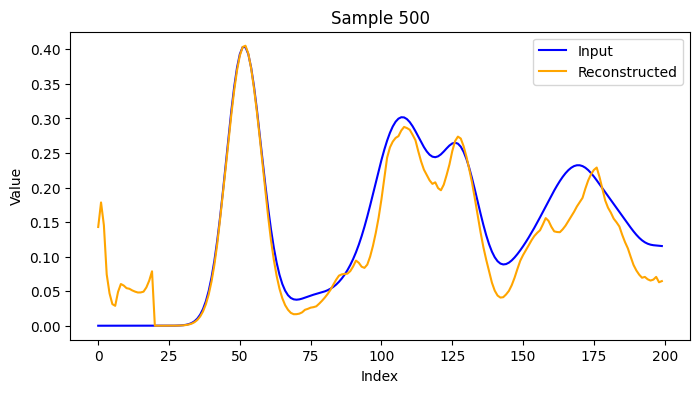

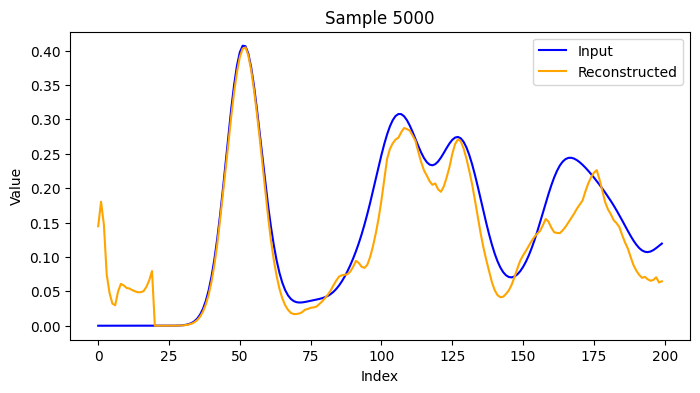

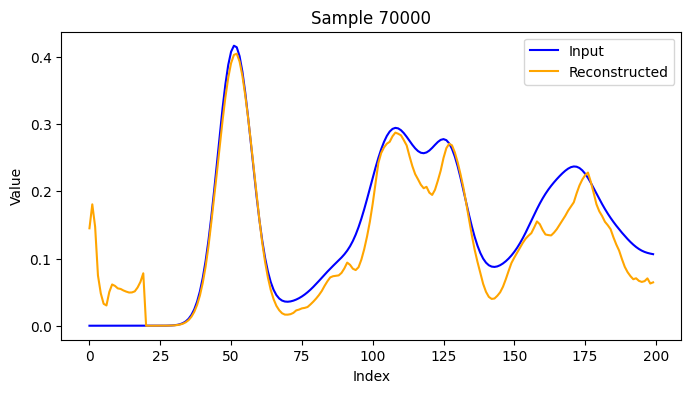

In [8]:
import os
import torch
from PyISV.neural_network import NeuralNetwork  # Import your model class
import numpy as np

# Load normalization parameters
input_scaler_subval = np.load("../norm_vals/input_autoen_scaler_subval.npy")
input_scaler_divval = np.load("../norm_vals/input_autoen_scaler_divval.npy")

model = NeuralNetwork(
    model_type="autoencoder",
    input_shape=(1, 200),         # Adjust based on your input data shape
    embed_dim=2,                  # Use the same parameters as the saved model
    encoder_channels=[8, 16, 32],
    decoder_channels=[32, 16, 8],
    activation_fn=torch.nn.ReLU,
    use_pooling=True,
    device=torch.device("cpu")    # Adjust device as needed
)

# Load the saved state dictionary
model_path = "../models/best_autoencoder_model.pth"  # Replace with your model path
checkpoint = torch.load(model_path)
state_dict = checkpoint["model_state_dict"]

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Load the saved traced model
#model_path = "../models/traced_autoencoder_model.pth"  # Replace with your model path
#model = torch.jit.load(model_path)
#model.eval()

# Load the input data
input_data_path = "../data/RDFs/rdf_images.pt"  # Replace with your input data path
input_data = torch.load(input_data_path).float()

# Create a folder to save reconstructed outputs
output_folder = "../data/reconstructed_outputs"
os.makedirs(output_folder, exist_ok=True)

# Reconstruct outputs
with torch.no_grad():
    for i in [1,500,5000,70000]:  # Process up to 5 samples
        input_signal = input_data[i].unsqueeze(0)  # Add batch dimension
        reconstructed_signal, _ = model(input_signal)  # Extract the reconstructed signal
        reconstructed_signal = (reconstructed_signal * input_scaler_divval) + input_scaler_subval
        
        # Plot and save the input and reconstructed signals
        plt.figure(figsize=(8, 4))
        plt.plot(input_signal.squeeze().cpu().numpy(), label="Input", color="blue")
        plt.plot(reconstructed_signal.squeeze().cpu().numpy(), label="Reconstructed", color="orange")
        plt.legend()
        plt.title(f"Sample {i}")
        plt.xlabel("Index")
        plt.ylabel("Value")

        output_path = os.path.join(output_folder, f"sample_{i}.png")
        #plt.savefig(output_path)
        #plt.close()

print(f"Reconstructed outputs saved in {output_folder}")